# Volume residual

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"
#star_file = "Projections/crossvalidation1/crossvalidation1.star"
star_file = "Projections/crossvalidation1_zeros/crossvalidation1_zeros.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  26380
load_data: data loaded, time:  38.697288274765015


In [4]:
print(jnp.max(imgs0))
print(jnp.mean(imgs0))

6.80121
0.0031396088


In [5]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)
nx0 = imgs0.shape[-1]
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()



(26380, 320, 320)
(26380,)
(26380, 3)
(26380, 2)
(26380, 9)


In [6]:
N = imgs0.shape[0]

if N < imgs0.shape[0]:
    idxrand = np.random.permutation(imgs0.shape)[:N]
else:
    idxrand = jnp.arange(N)
    
imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

#file2 = open(out_dir + '/idxrand','wb')
#pickle.dump(idxrand, file2)
#file2.close()

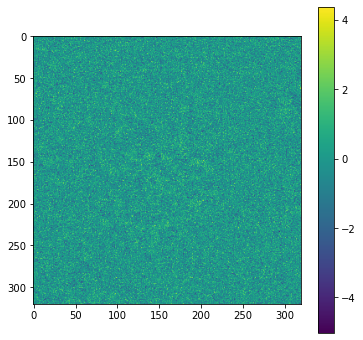

In [7]:
idx =123
plt.imshow(imgs0[idx]);plt.colorbar()

In [8]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

74.39393758773804


In [9]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 3.20000000e+02]


### Crop images

In [10]:
nx = 128 #64
x_grid_nx0 = x_grid
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid_nx0, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)



[2.38549618e-03 1.28000000e+02]


In [11]:
imgs_f = imgs_f.reshape(N,-1)
print(imgs_f.shape)

(26380, 16384)


### More processing

Text(0.5, 1.0, 'Estimated noise')

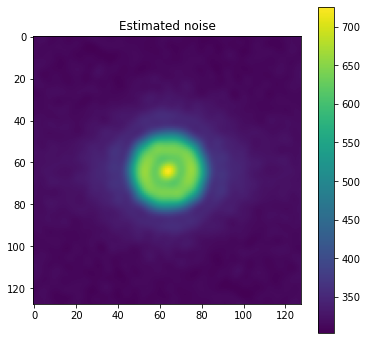

In [12]:
N_noise = 48
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

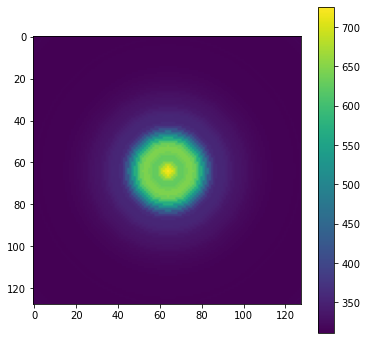

In [13]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

In [24]:
sigma_noise = sigma_noise_avg.reshape(-1)

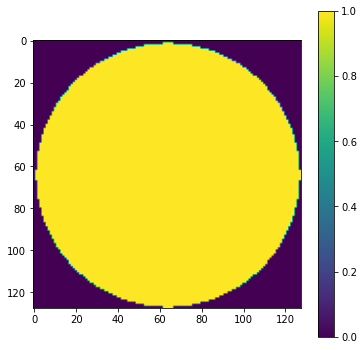

In [25]:
radius = 0.074 * 2.032
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Get residual

In [16]:
x_grid

array([2.38549618e-03, 1.28000000e+02])

In [17]:
jnp.complex128

jax._src.numpy.lax_numpy.complex128

In [18]:
mask2d = mask[0]

In [19]:
aa = jnp.array([[0,0],[0.1,0.1],[2,3], [0.14, 0.0001], [4, 20]])

In [20]:
aa.shape

(5, 2)

In [30]:
myidx = jnp.apply_along_axis(lambda x : x[0]**2 + x[1]**2 <= radius**2, axis=1, arr=aa)

In [31]:
myidx

DeviceArray([ True,  True, False,  True, False], dtype=bool)

In [32]:
aa[myidx]

DeviceArray([[0.0e+00, 0.0e+00],
             [1.0e-01, 1.0e-01],
             [1.4e-01, 1.0e-04]], dtype=float64)

In [33]:
x_grid

array([2.38549618e-03, 1.28000000e+02])

In [34]:
imgs_f.shape

(26380, 16384)

In [35]:
sigma_noise.shape

(16384,)

In [40]:
imgs_f[:10].shape

(10, 16384)

In [54]:
N_batches = 600 # for full dataset and 64

v_resid3, v_resid_counts3 = get_volume_residual(imgs_f, angles, sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 26380 images in 10 batches...done in 25.2413113117218 seconds.


TypeError: cannot unpack non-iterable NoneType object

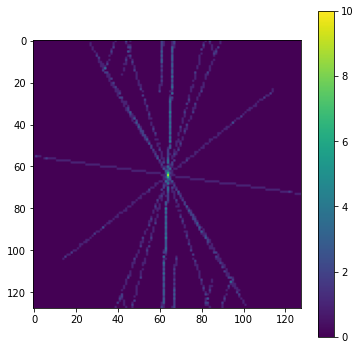

In [53]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid_counts[0]))); plt.colorbar()

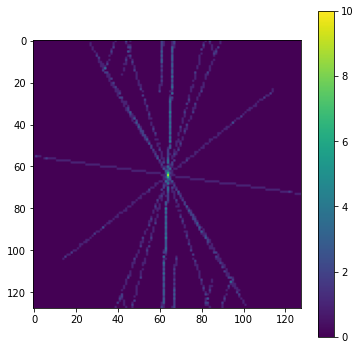

In [54]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid_counts2[0]))); plt.colorbar()

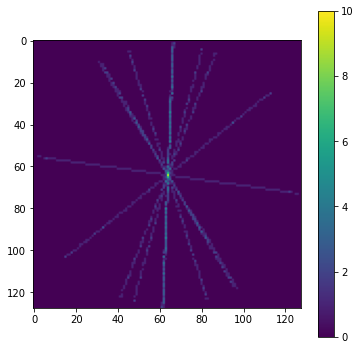

In [51]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid_counts3[0]))); plt.colorbar()

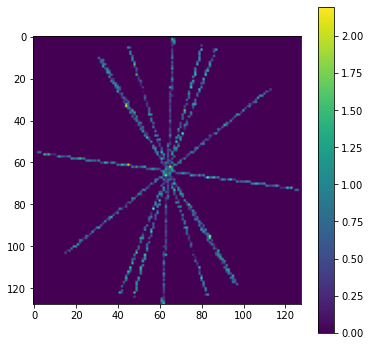

In [52]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid3[0]))); plt.colorbar()

In [43]:
imgs_f.shape

(26380, 128, 128)

In [56]:
mask.shape

(128, 128, 128)

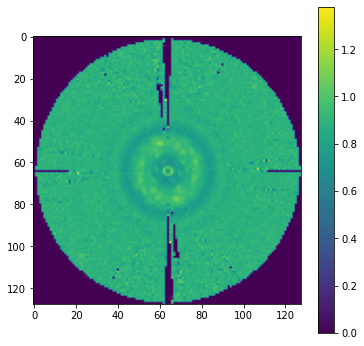

In [23]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)
with mrcfile.new('../data/cryodrgn_crossvalidation/v_resid_cv2_128.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [45]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_64.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_64_proj.mrc').data

In [36]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(5041074., dtype=float32)

In [25]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_128.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_128.mrc').data


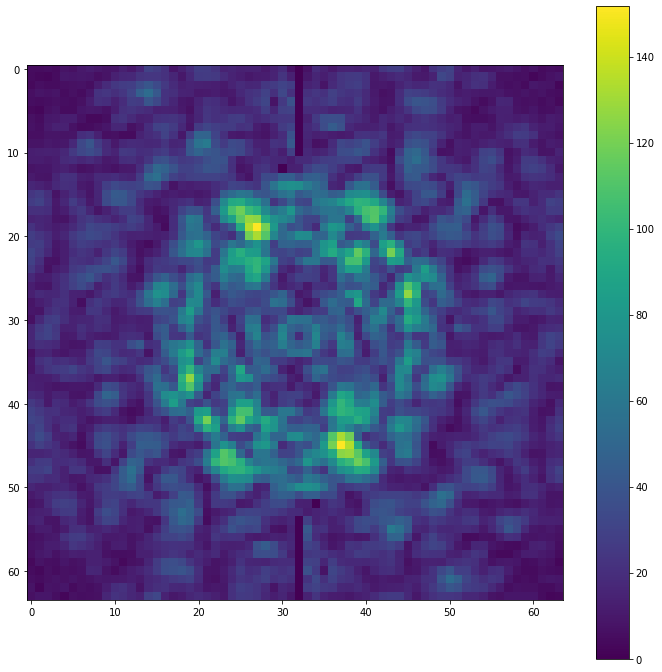

In [49]:
plt.imshow(rv[:,:,32]); plt.colorbar()

In [32]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(0., dtype=float32)

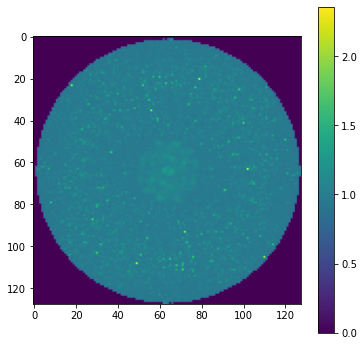

In [30]:
mip_z(rv); plt.colorbar()

### New volumes

In [24]:
with open('../data/cryodrgn_crossvalidation/cv1_proj_32', 'rb') as file:
    # Call load method to deserialze
    proj = pickle.load(file)


In [29]:
proj[0,0]

array([ 19.01725458,  35.90536084,  45.91661398,  16.16830083,
        -3.36572933, -13.29117774,  -6.34324598,   1.37270153,
         7.37385469,   6.56053346,   4.03242771,   2.40700772,
         3.34642496,   2.60984252,   1.15996835,   1.03297985,
        -0.04606021,   0.55394648,   0.81718212,   2.72114988,
         3.42498891,   2.42703735,   4.12682434,   6.56053346,
         7.37385469,   1.37270153,  -6.34324598, -13.29117774,
        -3.36572933,  16.16830083,  45.91661398,  35.90536084])